In [ ]:
pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.1/212.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.


In [ ]:
from openai import OpenAI
import pandas as pd
from datetime import datetime
from google.colab import drive
import time
drive.mount('/content/drive')

# assigning API KEY to initialize openai environment
client = OpenAI(
    # defaults to os.environ.get("OPENAI_API_KEY")
    api_key="X",
)

Mounted at /content/drive


In [ ]:
#def gpt_call_2(prompt1, prompt2, version): #ausgeklammert als Schutz nicht weitere Kosten zu verursachen
  try:
    chat_completion = client.chat.completions.create(
          messages=[
              {
                  "role": "system", "content": prompt1,
                  "role": "user", "content": prompt2
              }
          ],
          model=version,
          #model="gpt-4", #
          # Temperature: The temperature is usually set to the max value, 1. This is because we want the model to be as “random” as possible, while still staying within the constraints provided, to generate the most diverse dataset possible.
          temperature = 0.7,
          # Presence Penalty: Setting this parameter is a bit tricky. Higher presence penalty that model will be penalized if it generates the same word multiple times. This can be good if you want your dataset to be diverse and contain lots of different words. But if you are generating something very specific, you might want to have the same words present in your dataset multiple times in different contexts. The value of this parameter depends entirely on your requirement.
          #presence_penalty = 1,
          # Frequency Penalty: This value is also set to a higher number, 1.  A higher frequency penalty value will encourage the model to produce more diverse and unique content by penalizing the repetition of the same words or phrases.
          #frequency_penalty = 1,
          # Ich glaube aber, dass diese Einstellungen nur einen geringen Unterschied machen, weil ich pro Prompt nur eine Aussage generiere
          # Top_p sampling is an alternative to temperature sampling. Instead of considering all possible tokens, GPT-3 considers only a subset of tokens (the nucleus) whose cumulative probability mass adds up to a certain threshold (top_p).
          top_p = 0.8
    )
    response_message = chat_completion.choices[0].message.content
    print(response_message)
    return response_message

  except Exception as e:
    print(f"Error: {e}")
    reponse_message = "Error"
    return reponse_message


## Einlesen der Daten

In [ ]:
excel_file_path1 = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit/Neuer Test Januar/MaturityLevel-Information.xlsx'
excel_file_path2 = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit/Neuer Test Januar/Control-Information.xlsx'
excel_file_path3 = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit/Neuer Test Januar/Industry-Information.xlsx'
df_maturitylevel = pd.read_excel(excel_file_path1)
df_controls = pd.read_excel(excel_file_path2)
df_industry = pd.read_excel(excel_file_path3)

In [ ]:
df_industry.head(5)

,Industry,Industry Definition
0,Technology and Software,"It revolves around the development, production..."
1,Financial Services,"It encompasses the management, investment, tra..."
2,Healthcare and Pharmaceuticals,"It focuses on providing medical services, deve..."
3,Energy,"It focuses on the production, distribution, an..."
4,Retail,It encompasses the sale of goods and services ...


In [ ]:
df_controls.head(5)

,Control Nummer,Control,Control Definition
0,5.1,Policies for information security,Information security policy and topic-specific...
1,5.2,Information security roles and responsibilities,Information security roles and responsibilitie...
2,5.3,Segregation of duties,Conflicting duties and conflicting areas of re...
3,5.4,Management responsibilities,Management shall require all personnel to appl...
4,5.5,Contact with authorities,The organization shall establish and maintain ...


In [ ]:
df_maturitylevel.head(5)

,Maturity Level,Informations
0,1,Processes are usually ad hoc and chaotic. No s...
1,2,The organization's projects emphasize rigorous...
2,3,An organization has achieved the goals of both...
3,4,The organization has achieved goals from Level...
4,5,The organization has achieved goals from Level...


## Datenset-Vorbereitung

In [ ]:
columns = ['Maturity-Level', 'Maturity-Level Definition', 'Control-Number', 'Control', 'Control-Definition', 'Industry', 'Industry-Definition', 'Prompt_1', 'Prompt_2_formell', 'Prompt_2_informell', 'Statement-Formell', 'Statement-Informell']
df_prompts = pd.DataFrame(columns=columns)
df_prompts

,Maturity-Level,Maturity-Level Definition,Control-Number,Control,Control-Definition,Industry,Industry-Definition,Prompt_1,Prompt_2_formell,Prompt_2_informell,Statement-Formell,Statement-Informell


## Prompt Generation
Für Testzwecke erstelle ich erstmal nur 250 Formelle (125 GPT4 und 125 GPT4Turbo) und 250 Informelle Statements (125 GPT4 und 125 GPT4Turbo). Um diese miteinander vergleichen zu können, werde ich pro Beispiel die gleichen Controls und Branchen nutzen.
Um auf 500 Beispiele zu kommen, folgende Rechung:
Pro Control 5 Beispiele x 5 Maturity Levels * 2 Informell/Formell * 2 GPT4/Turbo = 50 Formelle und 50 Informelle Statements. Um auf die 500 zu kommen, teste ich das ganze also mit 5 Controls, die zufällig ausgewählt werden.
Industrie wird auch zufällig ausgewählt. ist aber bei Formell und Informell jeweils gleich.

### Zusätzlich teile ich nochmal in GPT4 und GPT4-Turbo auf, damit man die Unterscheidung auch vergleichen kann

In [ ]:
# testweise nur mit 10 Controls - Am Anfang hatte ich den Split zwischen GPT4 und Turbo noch nicht. Im Endeffekt habe ich nur 5 Controls genutzt
for i in range(10):
  selected_row = df_controls.sample(n=1)
  selected_ctrl_num = selected_row['Control Nummer'].values[0]
  selected_ctrl = selected_row['Control'].values[0]
  selected_ctrl_def = selected_row['Control Definition'].values[0]
  print(selected_ctrl_num)
  print(selected_ctrl)
  print(selected_ctrl_def)
  # Entfernen der ausgewählten Zeile aus dem DataFrame, damit nicht doppelt genutzt wird
  df_controls = df_controls[df_controls['Control Nummer'] != selected_ctrl_num]
  # 5 Beispiele pro Control
  for j in range(5):
    # Auswahl der Branche zufällig - Branche bleibt gleich für einen Durchlauf aller Maturity Level
    selected_row_ind = df_industry.sample(n=1)
    selected_ind = selected_row_ind['Industry'].values[0]
    selected_ind_def = selected_row_ind['Industry Definition'].values[0]
    print(selected_ind)
    print(selected_ind_def)
    # 5 Maturity Level
    for k in range(5):
        selected_row_mat = df_maturitylevel.iloc[k]
        selected_mat = selected_row_mat['Maturity Level']
        selected_mat_def = selected_row_mat['Informations']
        print(selected_mat)
        print(selected_mat_def)
        # Erstellen der Prompts
        # Prompt1
        prompt_1 = "You simulate a person responsible for information security in a {} company".format(selected_ind)
        prompt_2_formell = "In an interview, you will be asked about the company's information security processes or capabilities in relation to the control {} from the ISO27001. Generate a statement that fits into the maturity level {} according to CMMI. Each statement should consist of 3 sentences. Do not mention the maturity level. Output only the statement and no extra text.\nConnect the three following contexts in such a way that the statement is about the control, but the classification into the maturity level and the industry information is taken into account:\n1. {}: {}\n2. Maturity Level {}: {}\n3. Industry {}: {}".format(
            selected_ctrl,
            selected_mat,
            selected_ctrl,
            selected_ctrl_def,
            selected_mat,
            selected_mat_def,
            selected_ind,
            selected_ind_def
            )
        prompt_2_informell = "In an interview, you will be asked about the company's information security processes or capabilities in relation to the control {} from the ISO27001. Your style is rather informal like you are answering a question in person. Generate a statement that fits into the maturity level {} according to CMMI. Each statement should consist of 3 sentences. Do not mention the maturity level. Output only the statement and no extra text.\nConnect the three following contexts in such a way that the statement is about the control, but the classification into the maturity level and the industry information is taken into account:\n1. {}: {}\n2. Maturity Level {}: {}\n3. Industry {}: {}".format(
            selected_ctrl,
            selected_mat,
            selected_ctrl,
            selected_ctrl_def,
            selected_mat,
            selected_mat_def,
            selected_ind,
            selected_ind_def
            )
        # Append the values to df_prompts
        df_prompts = df_prompts.append({
            'Maturity-Level': selected_mat,
            'Maturity-Level Definition': selected_mat_def,
            'Control-Number': selected_ctrl_num,
            'Control': selected_ctrl,
            'Control-Definition': selected_ctrl_def,
            'Industry': selected_ind,
            'Industry-Definition': selected_ind_def,
            'Prompt_1': prompt_1,
            'Prompt_2_formell': prompt_2_formell,
            'Prompt_2_informell': prompt_2_informell
        }, ignore_index=True)


8.26
Application security requirements
Information security requirements shall be identified, specified and approved when developing or acquiring applications.
Media and Entertainment
It encompasses the creation, production, and distribution of content across various platforms, including film, television, music, and digital media, playing a vital role in culture and communication. In the context of information security, the media and entertainment industry faces unique challenges such as protecting intellectual property, defending against piracy and cyber-attacks on content distribution networks, and securing sensitive customer data. This industry is particularly marked by its reliance on digital technologies and global distribution networks, making it crucial to safeguard content and systems against unauthorized access and distribution, while maintaining the integrity and confidentiality of creative assets.
1
Processes are usually ad hoc and chaotic. No stable environment is provided.

<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = 

4
The organization has achieved goals from Levels 2, 3, and 4. The establishment of quantitative objectives for quality and process performance, aligned with customer and organizational needs, is a priority. Detailed measures are collected, analyzed, and used to identify and correct special causes of process variation. At maturity level 4, the performance of processes is controlled using statistical and other quantitative techniques and is quantitatively predictable. At maturity level 3, processes are only qualitatively predictable.
5
The organization has achieved goals from Levels 2 to 5. The focus of maturity level 5 is on continuous improvement. Emphasis is on both incremental and innovative technological improvements to enhance process performance. Rapid response to changes is facilitated by accelerating and sharing learning. Unlike Level 4, which addresses special causes, Level 5 focuses on common causes of variation, shifting process performance to meet established objectives whi

<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = 

3
An organization has achieved the goals of both Level 2 and 3 process areas. Processes are well-characterized, understood, and documented in standards, procedures, tools, and methods. Unlike Level 2, where standards may vary by project, at Level 3, they are tailored from the organization's set of standard processes for consistency. Processes at Level 3 are described in more detail and rigorously managed with a proactive approach, considering interrelationships and detailed measures of activities, work products, and services.
4
The organization has achieved goals from Levels 2, 3, and 4. The establishment of quantitative objectives for quality and process performance, aligned with customer and organizational needs, is a priority. Detailed measures are collected, analyzed, and used to identify and correct special causes of process variation. At maturity level 4, the performance of processes is controlled using statistical and other quantitative techniques and is quantitatively predictab

<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = 

5
The organization has achieved goals from Levels 2 to 5. The focus of maturity level 5 is on continuous improvement. Emphasis is on both incremental and innovative technological improvements to enhance process performance. Rapid response to changes is facilitated by accelerating and sharing learning. Unlike Level 4, which addresses special causes, Level 5 focuses on common causes of variation, shifting process performance to meet established objectives while maintaining predictability. Continuous improvement becomes ingrained in everyone's role, creating a cycle of enhancement.
Media and Entertainment
It encompasses the creation, production, and distribution of content across various platforms, including film, television, music, and digital media, playing a vital role in culture and communication. In the context of information security, the media and entertainment industry faces unique challenges such as protecting intellectual property, defending against piracy and cyber-attacks on c

<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = 

2
The organization's projects emphasize rigorous requirement management and disciplined process planning and execution. This ensures the retention of established practices during challenging times. Projects adhere to documented plans, and management can track progress at defined checkpoints. Stakeholder commitments are established and adjusted as needed, with strict control measures applied to ensure work products and services meet specified requirements and objectives.
3
An organization has achieved the goals of both Level 2 and 3 process areas. Processes are well-characterized, understood, and documented in standards, procedures, tools, and methods. Unlike Level 2, where standards may vary by project, at Level 3, they are tailored from the organization's set of standard processes for consistency. Processes at Level 3 are described in more detail and rigorously managed with a proactive approach, considering interrelationships and detailed measures of activities, work products, and ser

<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = 

4
The organization has achieved goals from Levels 2, 3, and 4. The establishment of quantitative objectives for quality and process performance, aligned with customer and organizational needs, is a priority. Detailed measures are collected, analyzed, and used to identify and correct special causes of process variation. At maturity level 4, the performance of processes is controlled using statistical and other quantitative techniques and is quantitatively predictable. At maturity level 3, processes are only qualitatively predictable.
5
The organization has achieved goals from Levels 2 to 5. The focus of maturity level 5 is on continuous improvement. Emphasis is on both incremental and innovative technological improvements to enhance process performance. Rapid response to changes is facilitated by accelerating and sharing learning. Unlike Level 4, which addresses special causes, Level 5 focuses on common causes of variation, shifting process performance to meet established objectives whi

<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = 

Automotive
It centers on the design, development, manufacturing, and marketing of motor vehicles, a sector integral to global transportation and economic progress. In terms of information security, the automotive industry faces unique challenges, including protecting proprietary design and engineering data, securing connected vehicle technologies from cyber-attacks, and safeguarding customer and supplier information. This industry is distinctively characterized by its rapid adoption of digital and autonomous technologies, which heightens the need for robust cybersecurity measures to ensure the safety and privacy of both drivers and vehicles.
1
Processes are usually ad hoc and chaotic. No stable environment is provided. Success depends on the competence and heroics of the people in the organization and not on the use of proven processes. Products and services work; however, they frequently exceed budget and schedule of projects.
2
The organization's projects emphasize rigorous requireme

<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = 


The organization's projects emphasize rigorous requirement management and disciplined process planning and execution. This ensures the retention of established practices during challenging times. Projects adhere to documented plans, and management can track progress at defined checkpoints. Stakeholder commitments are established and adjusted as needed, with strict control measures applied to ensure work products and services meet specified requirements and objectives.
3
An organization has achieved the goals of both Level 2 and 3 process areas. Processes are well-characterized, understood, and documented in standards, procedures, tools, and methods. Unlike Level 2, where standards may vary by project, at Level 3, they are tailored from the organization's set of standard processes for consistency. Processes at Level 3 are described in more detail and rigorously managed with a proactive approach, considering interrelationships and detailed measures of activities, work products, and serv

<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = 

2
The organization's projects emphasize rigorous requirement management and disciplined process planning and execution. This ensures the retention of established practices during challenging times. Projects adhere to documented plans, and management can track progress at defined checkpoints. Stakeholder commitments are established and adjusted as needed, with strict control measures applied to ensure work products and services meet specified requirements and objectives.
3
An organization has achieved the goals of both Level 2 and 3 process areas. Processes are well-characterized, understood, and documented in standards, procedures, tools, and methods. Unlike Level 2, where standards may vary by project, at Level 3, they are tailored from the organization's set of standard processes for consistency. Processes at Level 3 are described in more detail and rigorously managed with a proactive approach, considering interrelationships and detailed measures of activities, work products, and ser

<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = 

Luxury Goods
It involves the design, creation, and marketing of high-end products known for their quality, exclusivity, and brand prestige, catering to a niche market. In terms of information security, the luxury goods industry faces distinct challenges, including protecting against counterfeiting, safeguarding sensitive design and client data, and preventing cyber-attacks that could damage brand reputation. This sector is particularly characterized by its emphasis on brand integrity and exclusivity, making it essential to maintain stringent security measures to protect intellectual property and uphold the trust and loyalty of its discerning customer base
1
Processes are usually ad hoc and chaotic. No stable environment is provided. Success depends on the competence and heroics of the people in the organization and not on the use of proven processes. Products and services work; however, they frequently exceed budget and schedule of projects.
2
The organization's projects emphasize rigo

<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({
<ipython-input-26-0f8c900e514d>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prompts = df_prompts.append({


In [ ]:
df_prompts

,Maturity-Level,Maturity-Level Definition,Control-Number,Control,Control-Definition,Industry,Industry-Definition,Prompt_1,Prompt_2_formell,Prompt_2_informell,Statement-Formell,Statement-Informell
0,1,Processes are usually ad hoc and chaotic. No s...,8.26,Application security requirements,Information security requirements shall be ide...,Media and Entertainment,"It encompasses the creation, production, and d...",You simulate a person responsible for informat...,"In an interview, you will be asked about the c...","In an interview, you will be asked about the c...",NaN,NaN
1,2,The organization's projects emphasize rigorous...,8.26,Application security requirements,Information security requirements shall be ide...,Media and Entertainment,"It encompasses the creation, production, and d...",You simulate a person responsible for informat...,"In an interview, you will be asked about the c...","In an interview, you will be asked about the c...",NaN,NaN
2,3,An organization has achieved the goals of both...,8.26,Application security requirements,Information security requirements shall be ide...,Media and Entertainment,"It encompasses the creation, production, and d...",You simulate a person responsible for informat...,"In an interview, you will be asked about the c...","In an interview, you will be asked about the c...",NaN,NaN
3,4,The organization has achieved goals from Level...,8.26,Application security requirements,Information security requirements shall be ide...,Media and Entertainment,"It encompasses the creation, production, and d...",You simulate a person responsible for informat...,"In an interview, you will be asked about the c...","In an interview, you will be asked about the c...",NaN,NaN
4,5,The organization has achieved goals from Level...,8.26,Application security requirements,Information security requirements shall be ide...,Media and Entertainment,"It encompasses the creation, production, and d...",You simulate a person responsible for informat...,"In an interview, you will be asked about the c...","In an interview, you will be asked about the c...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
245,1,Processes are usually ad hoc and chaotic. No s...,8.17,Clock synchronization,The clocks of information processing systems u...,Luxury Goods,"It involves the design, creation, and marketin...",You simulate a person responsible for informat...,"In an interview, you will be asked about the c...","In an interview, you will be asked about the c...",NaN,NaN
246,2,The organization's projects emphasize rigorous...,8.17,Clock synchronization,The clocks of information processing systems u...,Luxury Goods,"It involves the design, creation, and marketin...",You simulate a person responsible for informat...,"In an interview, you will be asked about the c...","In an interview, you will be asked about the c...",NaN,NaN
247,3,An organization has achieved the goals of both...,8.17,Clock synchronization,The clocks of information processing systems u...,Luxury Goods,"It involves the design, creation, and marketin...",You simulate a person responsible for informat...,"In an interview, you will be asked about the c...","In an interview, you will be asked about the c...",NaN,NaN
248,4,The organization has achieved goals from Level...,8.17,Clock synchronization,The clocks of information processing systems u...,Luxury Goods,"It involves the design, creation, and marketin...",You simulate a person responsible for informat...,"In an interview, you will be asked about the c...","In an interview, you will be asked about the c...",NaN,NaN


In [ ]:
# Aktuelles Datum und Uhrzeit abrufen
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

# Verwenden Sie den formatierten Zeitstempel als Teil des Dateinamens
dateiname = f"/content/drive/MyDrive/Colab Notebooks/Masterarbeit/Neuer Test Januar/Prompts-Formell-Informell_{timestamp}.xlsx"
# Speichern Sie das DataFrame in eine Excel-Datei
df_prompts.to_excel(dateiname, index=False)  # 'output.xlsx' ist der Name der Ausgabedatei
# Ausgabe des Dateinamens
print(dateiname)

/content/drive/MyDrive/Colab Notebooks/Masterarbeit/Neuer Test Januar/Prompts-Formell-Informell_20240115115759.xlsx


In [ ]:
excel_file_path = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit/Neuer Test Januar/Prompts-Formell-Informell_20240115115759.xlsx'
df_statements = pd.read_excel(excel_file_path)
df_statements.head(5)

,Maturity-Level,Maturity-Level Definition,Control-Number,Control,Control-Definition,Industry,Industry-Definition,Prompt_1,Prompt_2_formell,Prompt_2_informell,Statement-Formell-GPT4,Statement-Informell-GPT4,Statement-Formell-GPT4Turbo,Statement-Informell-GPT4Turbo
0,1,Processes are usually ad hoc and chaotic. No s...,8.26,Application security requirements,Information security requirements shall be ide...,Media and Entertainment,"It encompasses the creation, production, and d...",You simulate a person responsible for informat...,"In an interview, you will be asked about the c...","In an interview, you will be asked about the c...",NaN,NaN,NaN,NaN
1,2,The organization's projects emphasize rigorous...,8.26,Application security requirements,Information security requirements shall be ide...,Media and Entertainment,"It encompasses the creation, production, and d...",You simulate a person responsible for informat...,"In an interview, you will be asked about the c...","In an interview, you will be asked about the c...",NaN,NaN,NaN,NaN
2,3,An organization has achieved the goals of both...,8.26,Application security requirements,Information security requirements shall be ide...,Media and Entertainment,"It encompasses the creation, production, and d...",You simulate a person responsible for informat...,"In an interview, you will be asked about the c...","In an interview, you will be asked about the c...",NaN,NaN,NaN,NaN
3,4,The organization has achieved goals from Level...,8.26,Application security requirements,Information security requirements shall be ide...,Media and Entertainment,"It encompasses the creation, production, and d...",You simulate a person responsible for informat...,"In an interview, you will be asked about the c...","In an interview, you will be asked about the c...",NaN,NaN,NaN,NaN
4,5,The organization has achieved goals from Level...,8.26,Application security requirements,Information security requirements shall be ide...,Media and Entertainment,"It encompasses the creation, production, and d...",You simulate a person responsible for informat...,"In an interview, you will be asked about the c...","In an interview, you will be asked about the c...",NaN,NaN,NaN,NaN


In [ ]:
df_statements = df_prompts
# 125 Prompts
# Formel und Informell (2)
# GPT4 vs GPT4 Turbo (2)
for i in range(len(df_statements)):
#for i in range(2):
  prompt_1 = df_statements.loc[i, 'Prompt_1']
  prompt_2_formell = df_statements.loc[i, 'Prompt_2_formell']
  prompt_2_informell = df_statements.loc[i, 'Prompt_2_informell']
  version = 'gpt-4'
  df_statements.at[i, 'Statement-Formell-GPT4'] = gpt_call_2(prompt_1, prompt_2_formell, version)
  time.sleep(3)
  df_statements.at[i, 'Statement-Informell-GPT4'] = gpt_call_2(prompt_1, prompt_2_informell, version)
  time.sleep(3)
  version = 'gpt-4-1106-preview'
  df_statements.at[i, 'Statement-Formell-GPT4Turbo'] = gpt_call_2(prompt_1, prompt_2_formell, version)
  time.sleep(3)
  df_statements.at[i, 'Statement-Informell-GPT4Turbo'] = gpt_call_2(prompt_1, prompt_2_informell, version)
  time.sleep(3)


  #print(prompt_1)
  #print(prompt_2_formell)
  #print(prompt_2_informell)

In our organization, the identification, specification, and approval of information security requirements during the development or acquisition of applications are crucial. However, our processes are often ad hoc and chaotic, heavily dependent on the expertise and heroics of our team rather than the use of proven processes. Given the nature of the Media and Entertainment industry, where we are faced with unique challenges like protecting intellectual property, defending against cyber-attacks, and securing sensitive customer data, we acknowledge the need for improved processes to ensure the security of our applications.
When it comes to application security requirements, we recognize their importance and make efforts to identify, specify, and approve them when developing or acquiring applications. However, our processes can be quite spontaneous and unstructured, largely relying on the skill and ingenuity of our team members. In our media and entertainment industry, where digital technol

KeyboardInterrupt: 

In [ ]:
# Aktuelles Datum und Uhrzeit abrufen
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

# Verwenden Sie den formatierten Zeitstempel als Teil des Dateinamens
dateiname = f"/content/drive/MyDrive/Colab Notebooks/Masterarbeit/Neuer Test Januar/Statements-Formell-Informell_{timestamp}.xlsx"
# Speichern Sie das DataFrame in eine Excel-Datei
df_statements.to_excel(dateiname, index=False)  # 'output.xlsx' ist der Name der Ausgabedatei
# Ausgabe des Dateinamens
print(dateiname)

/content/drive/MyDrive/Colab Notebooks/Masterarbeit/Neuer Test Januar/Statements-Formell-Informell_20240115151112.xlsx


In [ ]:
df_test = df_statements.head(125)

### Statement-Formell-GPT4

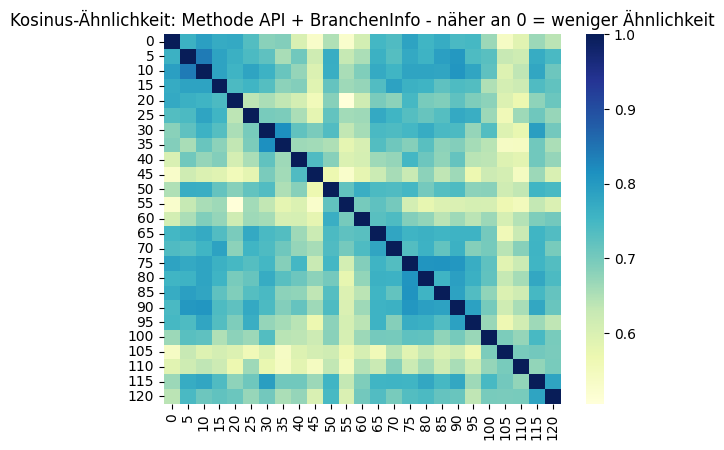

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Tokenisierung und Vektorisierung der Sätze
vectorizer = CountVectorizer().fit_transform(df_test['Statement-Formell-GPT4'])
satz_matrix = vectorizer.toarray()

# Berechnung der Kosinus-Ähnlichkeiten
cosine_similarities = cosine_similarity(satz_matrix)

# Erweitere das DataFrame um die Ähnlichkeitsmatrix
df_similarity = pd.DataFrame(cosine_similarities, index=df_test.index, columns=df_test.index)

# Ausgabe des DataFrame mit Ähnlichkeiten
df_similarity.head()


# Downsampling the DataFrame
downsampled_data = df_similarity.iloc[::5, ::5]  # Adjust the downsampling factor as needed

# Create a heatmap for the downsampled DataFrame
sns.heatmap(downsampled_data, cmap="YlGnBu", annot=False)
plt.title('Kosinus-Ähnlichkeit: Methode API + BranchenInfo - näher an 0 = weniger Ähnlichkeit')
plt.show()

### Statement-Informell-GPT4

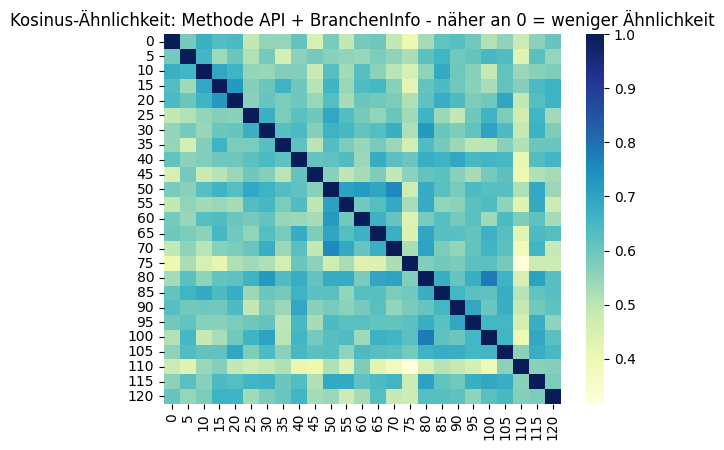

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Tokenisierung und Vektorisierung der Sätze
vectorizer = CountVectorizer().fit_transform(df_test['Statement-Informell-GPT4'])
satz_matrix = vectorizer.toarray()

# Berechnung der Kosinus-Ähnlichkeiten
cosine_similarities = cosine_similarity(satz_matrix)

# Erweitere das DataFrame um die Ähnlichkeitsmatrix
df_similarity = pd.DataFrame(cosine_similarities, index=df_test.index, columns=df_test.index)

# Ausgabe des DataFrame mit Ähnlichkeiten
df_similarity.head()


# Downsampling the DataFrame
downsampled_data = df_similarity.iloc[::5, ::5]  # Adjust the downsampling factor as needed

# Create a heatmap for the downsampled DataFrame
sns.heatmap(downsampled_data, cmap="YlGnBu", annot=False)
plt.title('Kosinus-Ähnlichkeit: Methode API + BranchenInfo - näher an 0 = weniger Ähnlichkeit')
plt.show()

### Statement-Formell-GPT4-Turbo

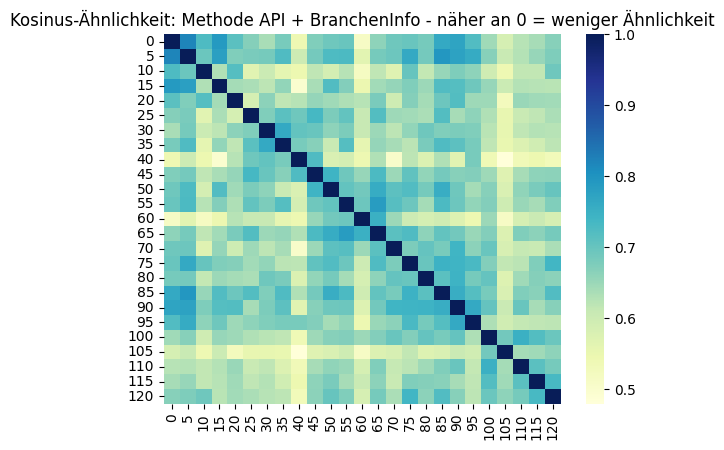

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Tokenisierung und Vektorisierung der Sätze
vectorizer = CountVectorizer().fit_transform(df_test['Statement-Formell-GPT4Turbo'])
satz_matrix = vectorizer.toarray()

# Berechnung der Kosinus-Ähnlichkeiten
cosine_similarities = cosine_similarity(satz_matrix)

# Erweitere das DataFrame um die Ähnlichkeitsmatrix
df_similarity = pd.DataFrame(cosine_similarities, index=df_test.index, columns=df_test.index)

# Ausgabe des DataFrame mit Ähnlichkeiten
df_similarity.head()


# Downsampling the DataFrame
downsampled_data = df_similarity.iloc[::5, ::5]  # Adjust the downsampling factor as needed

# Create a heatmap for the downsampled DataFrame
sns.heatmap(downsampled_data, cmap="YlGnBu", annot=False)
plt.title('Kosinus-Ähnlichkeit: Methode API + BranchenInfo - näher an 0 = weniger Ähnlichkeit')
plt.show()

### Statement-Informell-GPT4-Turbo

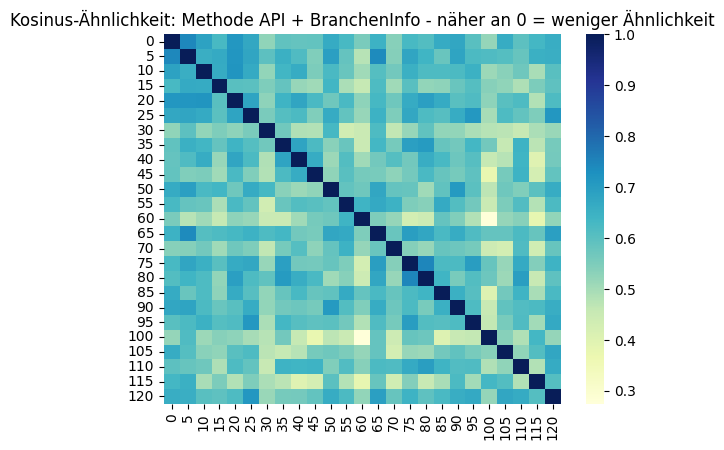

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Tokenisierung und Vektorisierung der Sätze
vectorizer = CountVectorizer().fit_transform(df_test['Statement-Informell-GPT4Turbo'])
satz_matrix = vectorizer.toarray()

# Berechnung der Kosinus-Ähnlichkeiten
cosine_similarities = cosine_similarity(satz_matrix)

# Erweitere das DataFrame um die Ähnlichkeitsmatrix
df_similarity = pd.DataFrame(cosine_similarities, index=df_test.index, columns=df_test.index)

# Ausgabe des DataFrame mit Ähnlichkeiten
df_similarity.head()


# Downsampling the DataFrame
downsampled_data = df_similarity.iloc[::5, ::5]  # Adjust the downsampling factor as needed

# Create a heatmap for the downsampled DataFrame
sns.heatmap(downsampled_data, cmap="YlGnBu", annot=False)
plt.title('Kosinus-Ähnlichkeit: Methode API + BranchenInfo - näher an 0 = weniger Ähnlichkeit')
plt.show()